<a href="https://colab.research.google.com/github/Eminent01/Baum-Tenpers-Research/blob/main/Baum_Tenper_Research3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock market Volatility forecast

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [42]:
data = pd.read_csv("/content/NSE All Share Historical Data.csv" , thousands =',')

In [43]:
data['log_price'] = np.log(data['Price']) #Firstly we should take the logarithmic return from prices

In [44]:
data['pct_change'] = data['log_price'].diff() #after that let's take difference

In [45]:
data['stdev'] = data['pct_change'].rolling(window=30, center=False).std()
data['Volatility'] = data['stdev'] * (252**0.5) # Annualize.

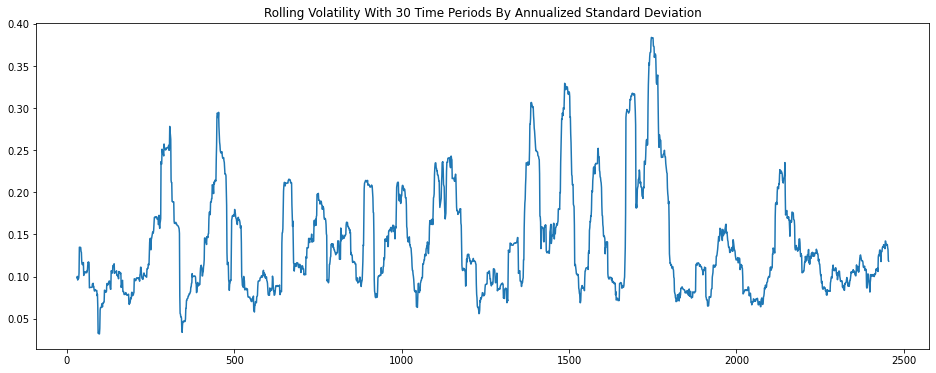

In [46]:
plt.figure(figsize=(16,6))
data['Volatility'].plot()
plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
plt.show()

In [47]:
data = data.dropna()

In [48]:
vol = data["Volatility"] * 100

In [23]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from arch import arch_model
am = arch_model(vol, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [50]:
res = am.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6133.60
Distribution:                  Normal   AIC:                           12275.2
Method:            Maximum Likelihood   BIC:                           12298.4
                                        No. Observations:                 2426
Date:                Fri, Nov 11 2022   Df Residuals:                     2425
Time:                        10:34:54   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.3475      0.197     52.520      0.000 [  9.961, 10.734]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.2586  5.972e-02      4.330  1.490e-05      [  0.142,  0.376]
alpha[1]       0.9729  3.397e-02     28.641 2.075e-180      [  0.906,  1.039]
beta[1]        0.0271  3.043e-02      0.890      0.373 [-3.255e-02,8.672e-02]
=============================================================================

Covariance estimator: robust
"""

In [51]:
data['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])

In [52]:
display(data.tail(10))

,Date,Price,Open,High,Low,Vol.,Change %,log_price,pct_change,stdev,Volatility,forecast_vol
2446,"Feb 13, 2012",20583.61,20615.26,20639.18,20582.32,-,-0.19%,9.932250,-0.004043,0.008945,0.141998,0.388683
2447,"Feb 10, 2012",20623.63,20629.60,20725.76,20622.01,-,-0.04%,9.934193,0.001942,0.008771,0.139234,0.362065
2448,"Feb 09, 2012",20631.38,20718.29,20719.85,20631.38,-,-0.30%,9.934568,0.000376,0.008739,0.138724,0.356401
2449,"Feb 08, 2012",20693.84,20781.62,20781.62,20660.71,-,-0.47%,9.937591,0.003023,0.008630,0.136993,0.339609
2450,"Feb 07, 2012",20790.88,20857.90,20903.00,20733.35,-,-0.42%,9.942270,0.004678,0.008671,0.137641,0.345373
2451,"Feb 03, 2012",20877.64,20822.00,20863.93,20786.35,-,0.27%,9.946434,0.004164,0.008694,0.138013,0.349104
2452,"Feb 02, 2012",20822.00,20872.94,20900.58,20785.40,-,0.15%,9.943765,-0.002669,0.008458,0.134269,0.313285
2453,"Feb 01, 2012",20790.88,20875.34,20941.03,20790.88,-,-0.41%,9.942270,-0.001496,0.008328,0.132209,0.292535
2454,"Jan 31, 2012",20875.83,20818.56,21009.92,20789.48,-,0.70%,9.946347,0.004078,0.007501,0.119072,0.169037
2455,"Jan 30, 2012",20731.72,20939.10,20950.02,20731.72,-,-0.77%,9.939420,-0.006927,0.007451,0.118286,0.157177


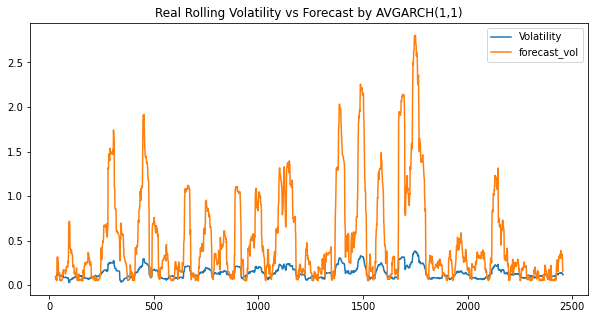

In [53]:
plt.figure(figsize=(10,5))
data["Volatility"].plot()
data["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by AVGARCH(1,1)")
plt.legend()
plt.show()

In [54]:
def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(data.loc[data.index[1000:], 'forecast_vol'], data.loc[data.index[1000:], 'Volatility'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  0.6741302111272742


In [31]:
data.iloc[:, 10:11]

,Volatility
30,0.141285
31,0.115366
32,0.115263
33,0.109820
34,0.111082
...,...
2452,0.132956
2453,0.133475
2454,0.132928
2455,0.127029


In [ ]:
training_set = data.iloc[:, 10:11].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(1000, data.shape[0]):
    X_train.append(training_set[i-1000:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
45/45 [==============================] - 71s 1s/step - loss: 0.0055
Epoch 2/100
45/45 [==============================] - 62s 1s/step - loss: 0.0029
Epoch 3/100
45/45 [==============================] - 60s 1s/step - loss: 0.0022
Epoch 4/100
45/45 [==============================] - 61s 1s/step - loss: 0.0019
Epoch 5/100
45/45 [==============================] - 60s 1s/step - loss: 0.0017
Epoch 6/100
45/45 [==============================] - 61s 1s/step - loss: 0.0016
Epoch 7/100
45/45 [==============================] - 59s 1s/step - loss: 0.0013
Epoch 8/100
45/45 [==============================] - 61s 1s/step - loss: 0.0012
Epoch 9/100
45/45 [==============================] - 59s 1s/step - loss: 0.0011
Epoch 10/100
45/45 [==============================] - 60s 1s/step - loss: 0.0010
Epoch 11/100
45/45 [==============================] - 61s 1s/step - loss: 9.6792e-04
Epoch 12/100
45/45 [==============================] - 60s 1s/step - loss: 9.6404e-04
Epoch 13/100
45/45 [=========

In [29]:
regressor.save('my_modelp1.h5')

In [30]:
from keras.models import load_model
regressor = load_model('my_modelp1.h5')

In [31]:
predicted_stock_price = regressor.predict(X_train)

45/45 [==============================] - 11s 200ms/step


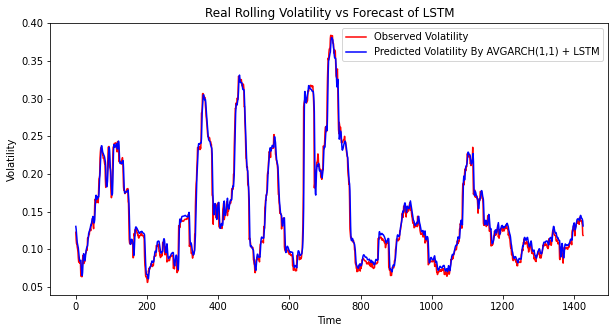

In [33]:

# Visualising the results
plt.figure(figsize=(10,5))
plt.plot(data.iloc[1000:, 10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By AVGARCH(1,1) + LSTM')
plt.title('Real Rolling Volatility vs Forecast of LSTM')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [35]:
skor2 = rmse_tr(predicted_stock_price, np.array(data.loc[data.index[1000:], 'Volatility']))
print("Root Mean Squared Error of the model is calculated as ",skor2)

Root Mean Squared Error of the model is calculated as  0.0975942398737033


In [16]:
data.iloc[:, 10:12]

,Volatility,forecast_vol
30,0.098477,0.092065
31,0.100191,0.062168
32,0.095856,0.091314
33,0.098100,0.074979
34,0.098132,0.074266
...,...,...
2451,0.138013,0.349104
2452,0.134269,0.313285
2453,0.132209,0.292535
2454,0.119072,0.169037


In [55]:
training_set = data.iloc[:, 10:12].values
# 100 timestep ve 1 çıktı ile data yapısı oluşturalım
X_train = []
y_train = []
for i in range(1000, data.shape[0]):
    X_train.append(training_set[i-1000:i,:])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
45/45 [==============================] - 68s 1s/step - loss: 0.0057
Epoch 2/100
45/45 [==============================] - 61s 1s/step - loss: 0.0027
Epoch 3/100
45/45 [==============================] - 61s 1s/step - loss: 0.0021
Epoch 4/100
45/45 [==============================] - 60s 1s/step - loss: 0.0019
Epoch 5/100
45/45 [==============================] - 59s 1s/step - loss: 0.0016
Epoch 6/100
45/45 [==============================] - 59s 1s/step - loss: 0.0015
Epoch 7/100
45/45 [==============================] - 59s 1s/step - loss: 0.0014
Epoch 8/100
45/45 [==============================] - 59s 1s/step - loss: 0.0013
Epoch 9/100
45/45 [==============================] - 58s 1s/step - loss: 0.0014
Epoch 10/100
45/45 [==============================] - 59s 1s/step - loss: 0.0011
Epoch 11/100
45/45 [==============================] - 59s 1s/step - loss: 0.0012
Epoch 12/100
45/45 [==============================] - 58s 1s/step - loss: 0.0011
Epoch 13/100
45/45 [=================

In [20]:
regressor.save('my_modelp2.h5')

In [57]:
from keras.models import load_model
regressor = load_model('my_modelp2.h5')

In [58]:
predicted_stock_price = regressor.predict(X_train)

45/45 [==============================] - 11s 203ms/step


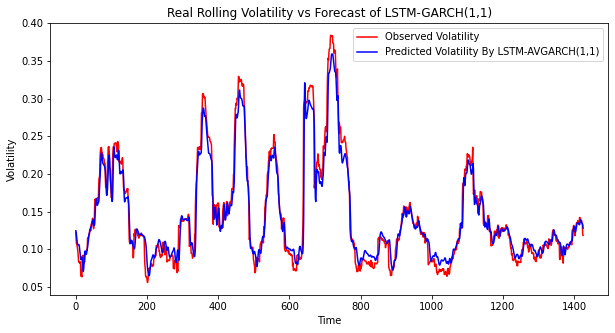

In [59]:
# Visualising the results
plt.figure(figsize=(10,5))
plt.plot(data.iloc[1000:, 10:11].values, color = 'red', label = 'Observed Volatility')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM-AVGARCH(1,1)')
plt.title('Real Rolling Volatility vs Forecast of LSTM-GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()